In [55]:
!pip install torchmetrics

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from diffusers import DDPMScheduler, DDIMScheduler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

from torch.utils.data import Subset

from diffusers.models.embeddings import TimestepEmbedding, get_timestep_embedding

from torchmetrics import JaccardIndex




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

DATA_DIR = './data'
BATCH_SIZE = 64

BASELINE_MODEL = "deeplabv3"  # Options: "unet" or "deeplabv3"
print(f"Selected baseline model: {BASELINE_MODEL}")

BINARY_SEGMENTATION = False  # if False → 3-class (Pet, Background, Boundary)
NUM_CLASSES = 2 if BINARY_SEGMENTATION else 3
print(f"Segmentation mode: {'Binary' if BINARY_SEGMENTATION else '3-class'} ({NUM_CLASSES} output channel(s))")

USE_SUBSET = True
SUBSET_RATIO=0.2

MODEL_CONFIGS = {
    "unet": {
        "image_size": 128,
        "normalize": False
    },
    "deeplabv3": {
        "image_size": 128,
        "normalize": True   # Uses ImageNet normalization
    }
}

config = MODEL_CONFIGS[BASELINE_MODEL]
IMAGE_SIZE = config["image_size"]
print(f"Using image size: {IMAGE_SIZE}x{IMAGE_SIZE}")

Using device: cuda
GPU: NVIDIA L4
Selected baseline model: deeplabv3
Segmentation mode: 3-class (3 output channel(s))
Using image size: 128x128


In [43]:
# Initialize selected baseline model
model_path = f'baseline_{BASELINE_MODEL}_{NUM_CLASSES}_classes.pth'
print(model_path)

baseline_deeplabv3_3_classes.pth


In [44]:
def preprocess_mask(mask):
    """
    Convert raw mask (1=Pet, 2=Background, 3=Boundary)
    → binary (Pet+Boundary vs Background) or 3-class tensor.
    """
    mask = mask.squeeze()
    if BINARY_SEGMENTATION:
      mask = ((mask == 1) | (mask == 3)).float()
    else:
      mask = (mask.long() - 1).clamp(0, 2)  # shift [1,2,3] → [0,1,2]
    return mask

3680 3669
Using subset: 736 train samples, 733 test samples

Train samples: 736 | Test samples: 733 — Data loaders ready!

Image batch shape: torch.Size([64, 3, 128, 128]), Mask batch shape: torch.Size([64, 128, 128])
Image min: -2.118, max: 2.640
Mask unique values: tensor([0, 1, 2])


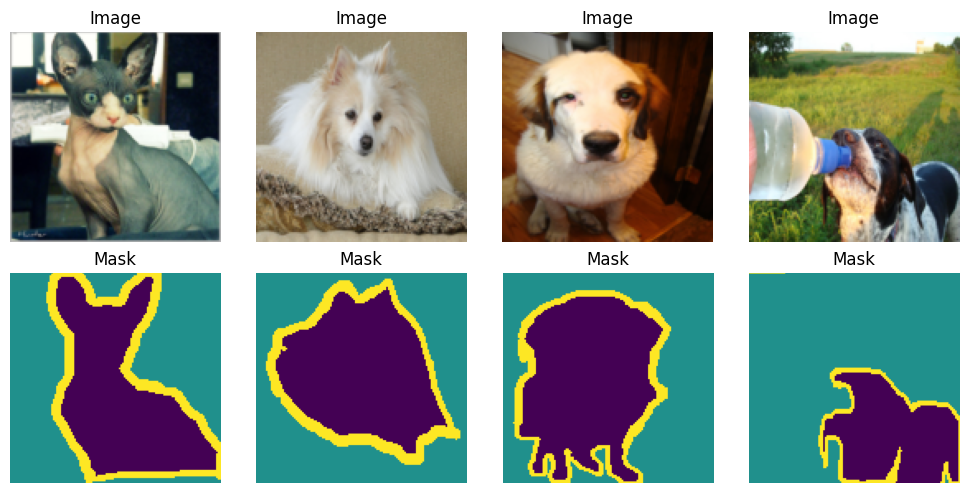

In [49]:
if BASELINE_MODEL == "deeplabv3":
    weights = DeepLabV3_ResNet50_Weights.DEFAULT
    mean = [0.485, 0.456, 0.406]  # ImageNet statistics
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
else: # unet
    normalize = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

# Mask transforms
target_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

# Load full datasets
train_ds = datasets.OxfordIIITPet(
    DATA_DIR, split='trainval', download=True, target_types='segmentation',
    transform=normalize, target_transform=target_tf
)
test_ds = datasets.OxfordIIITPet(
    DATA_DIR, split='test', download=True, target_types='segmentation',
    transform=normalize, target_transform=target_tf
)

print(len(train_ds), len(test_ds))

# use only a subset
if USE_SUBSET:
    n_train = int(len(train_ds) * SUBSET_RATIO)
    n_test = int(len(test_ds) * SUBSET_RATIO)
    train_idx = np.random.choice(len(train_ds), n_train, replace=False)
    test_idx = np.random.choice(len(test_ds), n_test, replace=False)
    train_ds = Subset(train_ds, train_idx)
    test_ds = Subset(test_ds, test_idx)
    print(f"Using subset: {n_train} train samples, {n_test} test samples")

# DataLoaders
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack([preprocess_mask(t) for t in targets])
    return images, masks

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"\nTrain samples: {len(train_ds)} | Test samples: {len(test_ds)} — Data loaders ready!")

# Inspect a few samples
images, masks = next(iter(train_loader))
print(f"\nImage batch shape: {images.shape}, Mask batch shape: {masks.shape}")
print(f"Image min: {images.min().item():.3f}, max: {images.max().item():.3f}")
print(f"Mask unique values: {torch.unique(masks)}")

# Denormalization helper
def denormalize(img, mean, std):
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Visualize samples
n_samples = min(BATCH_SIZE, 4)
plt.figure(figsize=(10, 5))
for i in range(n_samples):
    img = images[i]
    mask = masks[i].squeeze()

    if BASELINE_MODEL == "deeplabv3":
        img = denormalize(img, mean, std)

    img = img.permute(1, 2, 0).numpy().clip(0, 1)
    mask = mask.numpy()

    plt.subplot(2, n_samples, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Mask")

plt.tight_layout()
plt.show()

In [50]:


# Define U-Net architecture
class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base=64):
        super().__init__()
        self.enc1 = self._conv_block(in_ch, base)
        self.enc2 = self._conv_block(base, base * 2)
        self.enc3 = self._conv_block(base * 2, base * 4)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = self._conv_block(base * 4 + base * 2, base * 2)
        self.dec1 = self._conv_block(base * 2 + base, base)
        self.final = nn.Conv2d(base, out_ch, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.up(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.final(d1)

if BASELINE_MODEL.lower() == "unet":
    baseline_model = UNetSmall(in_ch=3, out_ch=NUM_CLASSES).to(device)
    print("Initialized custom U-Net baseline model.")

elif BASELINE_MODEL.lower() == "deeplabv3":
    weights = DeepLabV3_ResNet50_Weights.DEFAULT
    baseline_model = deeplabv3_resnet50(weights=weights)
    baseline_model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
    baseline_model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
    baseline_model = baseline_model.to(device)
    print(f"Initialized DeepLabV3 baseline (pretrained) with num_classes={NUM_CLASSES}.")

else:
    raise ValueError(f"Unknown baseline model: {BASELINE_MODEL}")

# Model summary
total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Baseline model parameters: {total_params:,}")


Initialized DeepLabV3 baseline (pretrained) with num_classes=3.
Baseline model parameters: 41,994,822


In [51]:

train_losses = []

if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}...")
    baseline_model.load_state_dict(torch.load(model_path, map_location=device))
    baseline_model.eval()
    print("Pre-trained model loaded successfully. Skipping training.")
else:
    print(f"No pre-trained model found at {model_path}. Training new model...")
    num_epochs = 5
    criterion = nn.CrossEntropyLoss()

    # U-Net training
    if BASELINE_MODEL.lower() == "unet":
        optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-4)
        baseline_model.train()
        print(f"Training {BASELINE_MODEL.upper()} for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = baseline_model(images)  # (N, NUM_CLASSES, H, W)
                loss = criterion(outputs, masks.long())

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

    # DeepLabV3 training
    elif BASELINE_MODEL.lower() == "deeplabv3":
        for param in baseline_model.backbone.parameters():
            param.requires_grad = False

        optimizer = torch.optim.Adam([
            {"params": baseline_model.classifier.parameters(), "lr": 1e-4},
            {"params": baseline_model.aux_classifier.parameters(), "lr": 1e-4}
        ])

        baseline_model.train()
        print(f"Fine-tuning {BASELINE_MODEL.upper()} for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            epoch_loss = 0.0

            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = baseline_model(images)
                main_out = outputs["out"]
                aux_out = outputs.get("aux")

                loss = criterion(main_out, masks.long())
                if aux_out is not None:
                    loss += 0.4 * criterion(aux_out, masks.long())

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

    else:
        raise ValueError(f"Unknown baseline model: {BASELINE_MODEL}")

    # Save trained model
    torch.save(baseline_model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    print("Baseline training completed!")

# Sanity check
baseline_model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    preds = baseline_model(test_images[:1]) if BASELINE_MODEL.lower() == "unet" else baseline_model(test_images[:1])["out"]
    print(f"Sanity check — test output shape: {preds.shape}")


No pre-trained model found at baseline_deeplabv3_3_classes.pth. Training new model...
Fine-tuning DEEPLABV3 for 5 epochs...


Epoch 1/5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 1.2062


Epoch 2/5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.8231


Epoch 3/5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.6914


Epoch 4/5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.6304


Epoch 5/5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.5913
Model saved to baseline_deeplabv3_3_classes.pth
Baseline training completed!
Sanity check — test output shape: torch.Size([1, 3, 128, 128])


Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]



Mean IoU on test set (TorchMetrics): 0.5832


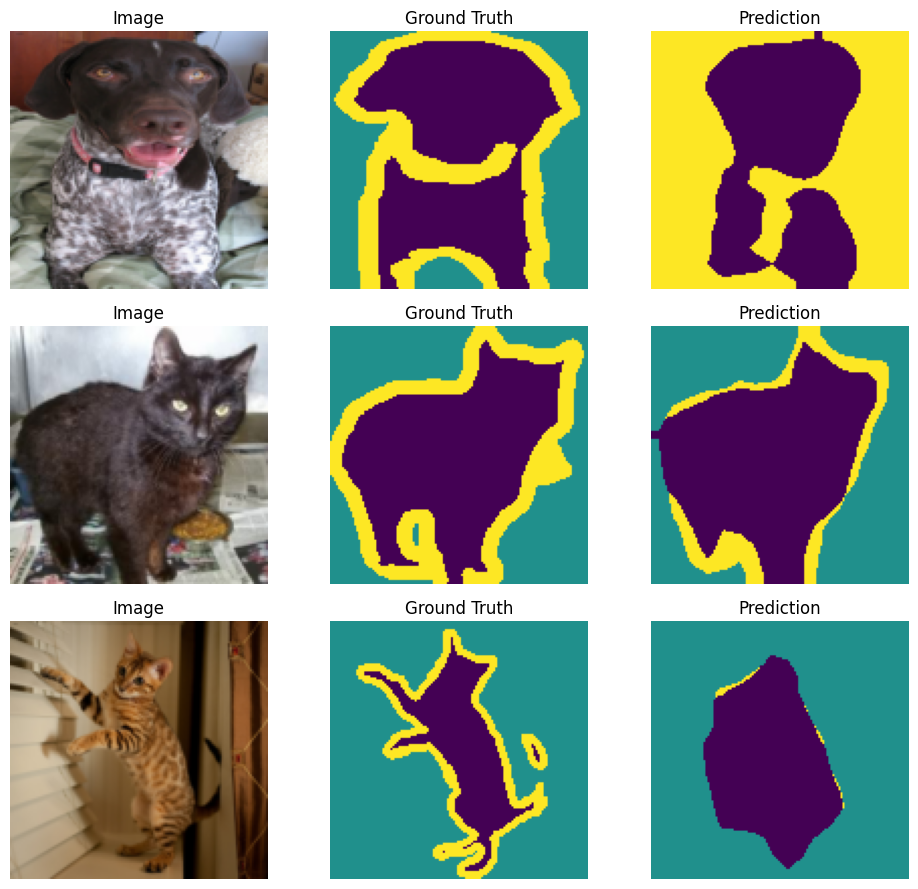

In [101]:
# Initialize
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(device)

baseline_model.eval()
ious = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating"):
        images, masks = images.to(device), masks.to(device)

        if BASELINE_MODEL.lower() == "unet":
            logits = baseline_model(images)
        else:
            logits = baseline_model(images)["out"]

        preds = torch.argmax(logits, dim=1)
        iou = iou_metric(preds, masks.long())
        ious.append(iou.item())

mean_iou = np.mean(ious)
print(f"\nMean IoU on test set (TorchMetrics): {mean_iou:.4f}")


# Visualization
n_vis = 3
images, masks = next(iter(test_loader))
images, masks = images[:n_vis].to(device), masks[:n_vis].to(device)

with torch.no_grad():
    if BASELINE_MODEL.lower() == "unet":
        logits = baseline_model(images)
    else:
        logits = baseline_model(images)["out"]
    preds = torch.argmax(logits, dim=1)

plt.figure(figsize=(10, n_vis * 3))
for i in range(n_vis):
    img = images[i].cpu()
    if BASELINE_MODEL.lower() == "deeplabv3":
        img = denormalize(img, mean, std)
    img = img.permute(1, 2, 0).numpy().clip(0, 1)

    gt = masks[i].cpu().numpy()
    pr = preds[i].cpu().numpy()

    plt.subplot(n_vis, 3, i * 3 + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(n_vis, 3, i * 3 + 2)
    plt.imshow(gt)
    plt.axis("off")
    plt.title("Ground Truth")

    plt.subplot(n_vis, 3, i * 3 + 3)
    plt.imshow(pr)
    plt.axis("off")
    plt.title("Prediction")

plt.tight_layout()
plt.show()


In [127]:
class ConditionalUNet(nn.Module):
    def __init__(self, img_channels=3, x_channels=None, cond_channels=None, base_channels=64):
        super().__init__()
        # x_channels is the noisy mask channels (NUM_CLASSES)
        in_channels = img_channels + x_channels + cond_channels

        self.base = base_channels
        # small MLP to project timestep embeddings
        self.time_dim = base_channels

        # get_timestep_embedding returns [B, time_dim]; project to base*4 channels to add to bottleneck
        self.time_mlp = nn.Sequential(
            nn.Linear(self.time_dim, self.time_dim * 4),
            nn.ReLU(),
            nn.Linear(self.time_dim * 4, base_channels * 4)
        )

        # Encoder
        self.enc1 = self._block(in_channels, base_channels)
        self.enc2 = self._block(base_channels, base_channels * 2)
        self.enc3 = self._block(base_channels * 2, base_channels * 4)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self._block(base_channels * 4, base_channels * 4)

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = self._block(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = self._block(base_channels * 2, base_channels)

        # Predict noise (epsilon) in mask/logit space: output channels == x_channels
        self.out_conv = nn.Conv2d(base_channels, x_channels, kernel_size=1)

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, img, x_noisy, cond_logits, t):
        """
        img: [B, 3, H, W]
        x_noisy: [B, NUM_CLASSES, H, W]   # noisy sample at timestep t (same dtype/range as logits)
        cond_logits: [B, NUM_CLASSES, H, W]  # clean baseline logits (or other conditioning)
        t: [B] long tensor of timesteps
        Returns: predicted noise epsilon (same shape as x_noisy)
        """
        # build input
        x = torch.cat([img, x_noisy, cond_logits], dim=1)  # [B, in_channels, H, W]

        emb = get_timestep_embedding(t, self.time_dim)  # [B, time_dim]
        t_proj = self.time_mlp(emb)  # [B, base_channels*4]
        t_proj = t_proj[:, :, None, None]  # [B, C, 1, 1]

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck + time
        b = self.bottleneck(e3)
        b = b + t_proj

        # Decoder
        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)  # predicted noise eps



In [158]:
# Diffusion Refiner Setup
diffusion_model = ConditionalUNet(
    img_channels=3,             # RGB conditioning
    x_channels=NUM_CLASSES, # noise lives in mask space
    cond_channels=NUM_CLASSES,  # baseline mask conditioning
    base_channels=64
).to(device)

ddpm_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-4,
    beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon"
)

optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4)
num_epochs = 75

for epoch in range(num_epochs):
    diffusion_model.train()
    epoch_loss = 0.0

    for imgs, masks in tqdm(train_loader, desc=f"Diff Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)

        with torch.no_grad():
            if BASELINE_MODEL.lower() == "unet":
                baseline_logits = baseline_model(imgs)  # raw logits
            else:
                baseline_logits = baseline_model(imgs)["out"]

        # This is the clean sample we will corrupt: use logits
        clean = baseline_logits  # [B, C, H, W]
        noise = torch.randn_like(clean)
        t = torch.randint(0, ddpm_scheduler.config.num_train_timesteps, (imgs.size(0),), device=device).long()

        # produce noisy sample at timestep t (DDPM forward)
        x_noisy = ddpm_scheduler.add_noise(clean, noise, t)

        optimizer.zero_grad()
        # Model predicts epsilon/noise given x_noisy
        noise_pred = diffusion_model(imgs, x_noisy, clean, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} avg loss: {avg:.6f}")

# Save trained diffusion refiner weights
torch.save(
    diffusion_model.state_dict(),
    f"diffusion_refiner_baseline_{BASELINE_MODEL}_{NUM_CLASSES}_classes.pth"
)
print("Diffusion refiner training complete and model saved.")

Diff Epoch 1/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/75 avg loss: 0.954317


Diff Epoch 2/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/75 avg loss: 0.676726


Diff Epoch 3/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/75 avg loss: 0.479271


Diff Epoch 4/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/75 avg loss: 0.347169


Diff Epoch 5/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/75 avg loss: 0.251090


Diff Epoch 6/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/75 avg loss: 0.212574


Diff Epoch 7/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/75 avg loss: 0.178466


Diff Epoch 8/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/75 avg loss: 0.165259


Diff Epoch 9/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/75 avg loss: 0.152941


Diff Epoch 10/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/75 avg loss: 0.138342


Diff Epoch 11/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/75 avg loss: 0.132810


Diff Epoch 12/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/75 avg loss: 0.120368


Diff Epoch 13/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/75 avg loss: 0.116521


Diff Epoch 14/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/75 avg loss: 0.105101


Diff Epoch 15/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/75 avg loss: 0.104898


Diff Epoch 16/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/75 avg loss: 0.097283


Diff Epoch 17/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/75 avg loss: 0.102523


Diff Epoch 18/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/75 avg loss: 0.088460


Diff Epoch 19/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/75 avg loss: 0.076952


Diff Epoch 20/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/75 avg loss: 0.087320


Diff Epoch 21/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21/75 avg loss: 0.080016


Diff Epoch 22/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22/75 avg loss: 0.073642


Diff Epoch 23/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23/75 avg loss: 0.073970


Diff Epoch 24/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24/75 avg loss: 0.069118


Diff Epoch 25/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25/75 avg loss: 0.077884


Diff Epoch 26/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26/75 avg loss: 0.071074


Diff Epoch 27/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 27/75 avg loss: 0.060827


Diff Epoch 28/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28/75 avg loss: 0.066969


Diff Epoch 29/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29/75 avg loss: 0.062107


Diff Epoch 30/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30/75 avg loss: 0.065769


Diff Epoch 31/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 31/75 avg loss: 0.061952


Diff Epoch 32/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 32/75 avg loss: 0.065838


Diff Epoch 33/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 33/75 avg loss: 0.060115


Diff Epoch 34/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 34/75 avg loss: 0.059122


Diff Epoch 35/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 35/75 avg loss: 0.057629


Diff Epoch 36/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 36/75 avg loss: 0.056029


Diff Epoch 37/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 37/75 avg loss: 0.054054


Diff Epoch 38/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 38/75 avg loss: 0.053659


Diff Epoch 39/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 39/75 avg loss: 0.047552


Diff Epoch 40/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 40/75 avg loss: 0.053300


Diff Epoch 41/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 41/75 avg loss: 0.054274


Diff Epoch 42/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 42/75 avg loss: 0.053275


Diff Epoch 43/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 43/75 avg loss: 0.048684


Diff Epoch 44/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 44/75 avg loss: 0.049769


Diff Epoch 45/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 45/75 avg loss: 0.055433


Diff Epoch 46/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 46/75 avg loss: 0.044806


Diff Epoch 47/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 47/75 avg loss: 0.052742


Diff Epoch 48/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 48/75 avg loss: 0.046355


Diff Epoch 49/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 49/75 avg loss: 0.047671


Diff Epoch 50/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 50/75 avg loss: 0.041721


Diff Epoch 51/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 51/75 avg loss: 0.042351


Diff Epoch 52/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 52/75 avg loss: 0.040507


Diff Epoch 53/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 53/75 avg loss: 0.040289


Diff Epoch 54/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 54/75 avg loss: 0.043765


Diff Epoch 55/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 55/75 avg loss: 0.038839


Diff Epoch 56/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 56/75 avg loss: 0.049443


Diff Epoch 57/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 57/75 avg loss: 0.040560


Diff Epoch 58/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 58/75 avg loss: 0.039985


Diff Epoch 59/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 59/75 avg loss: 0.044830


Diff Epoch 60/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 60/75 avg loss: 0.035163


Diff Epoch 61/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 61/75 avg loss: 0.040986


Diff Epoch 62/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 62/75 avg loss: 0.037025


Diff Epoch 63/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 63/75 avg loss: 0.035281


Diff Epoch 64/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 64/75 avg loss: 0.036040


Diff Epoch 65/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 65/75 avg loss: 0.033733


Diff Epoch 66/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 66/75 avg loss: 0.034509


Diff Epoch 67/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 67/75 avg loss: 0.037188


Diff Epoch 68/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 68/75 avg loss: 0.040833


Diff Epoch 69/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 69/75 avg loss: 0.033659


Diff Epoch 70/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 70/75 avg loss: 0.033083


Diff Epoch 71/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 71/75 avg loss: 0.036382


Diff Epoch 72/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 72/75 avg loss: 0.033810


Diff Epoch 73/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 73/75 avg loss: 0.032808


Diff Epoch 74/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 74/75 avg loss: 0.031152


Diff Epoch 75/75:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 75/75 avg loss: 0.031869
Diffusion refiner training complete and model saved.


In [159]:
def refine_with_diffusion(image, baseline_model, diffusion_model, scheduler, num_steps=10, device=device):
    """
    image: [3, H, W] tensor
    baseline_model: returns logits (raw)
    diffusion_model: trained ConditionalUNet (predicts eps)
    scheduler: DDPMScheduler configured with prediction_type="epsilon"
    num_steps: number of reverse steps to run
    """
    diffusion_model.eval()
    with torch.no_grad():
        # 1) get baseline logits (clean)
        preds = baseline_model(image.unsqueeze(0).to(device))
        if isinstance(preds, dict):
            clean_logits = preds["out"]
        else:
            clean_logits = preds  # [1, C, H, W]

        clean_logits = clean_logits.to(device)

        # 2) choose timesteps for sampling
        scheduler.set_timesteps(num_steps)
        timesteps = scheduler.timesteps  # descending sequence

        # 3) sample initial x_T by adding noise at the first timestep
        T = timesteps[0].to(device)
        noise = torch.randn_like(clean_logits)
        x = scheduler.add_noise(clean_logits, noise, torch.tensor([T], device=device).repeat(clean_logits.shape[0]))  # [1, C, H, W]

        # 4) reverse loop
        for t in timesteps:
            t_tensor = torch.tensor([int(t)], device=device).repeat(clean_logits.shape[0])
            # model predicts eps
            eps_pred = diffusion_model(image.unsqueeze(0).to(device), x, clean_logits, t_tensor)
            # scheduler.step expects (model_output, timestep, sample)
            step = scheduler.step(eps_pred, t, x)
            # step may be a namedtuple depending on diffusers; prev_sample often at .prev_sample
            x = step.prev_sample if hasattr(step, "prev_sample") else step["prev_sample"]

        # final refined logits (clamp for safety)
        refined_logits = x
        refined_probs = F.softmax(refined_logits, dim=1)
    return refined_probs.squeeze(0).cpu()



In [160]:
baseline_model.eval()
diffusion_model.eval()

ious_refined = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating diffusion refinement"):
        images, masks = images.to(device), masks.to(device)

        #  Baseline Prediction (used for conditioning only)
        if BASELINE_MODEL.lower() == "unet":
            logits = baseline_model(images)
        else:
            logits = baseline_model(images)["out"]

        baseline_probs = F.softmax(logits, dim=1)

        #  Diffusion Refinement
        refined_batch = []
        for i in range(images.size(0)):
            refined = refine_with_diffusion(
                images[i],
                baseline_model,
                diffusion_model,
                ddpm_scheduler,
                num_steps=10,
            )
            refined_batch.append(refined.to(device))

        refined_batch = torch.stack(refined_batch)  # [B, C, H, W]
        preds_refined = torch.argmax(refined_batch, dim=1)

        #  IoU Calculation
        iou_r = iou_metric(preds_refined, masks.long())
        ious_refined.append(iou_r.item())

mean_iou_refined = np.mean(ious_refined)

print(f"\nRefined Mean IoU: {mean_iou_refined:.4f}")


Evaluating diffusion refinement:   0%|          | 0/12 [00:00<?, ?it/s]


Refined Mean IoU: 0.5913



Baseline IoU (visual samples): 0.5091
Refined IoU (visual samples):  0.5204



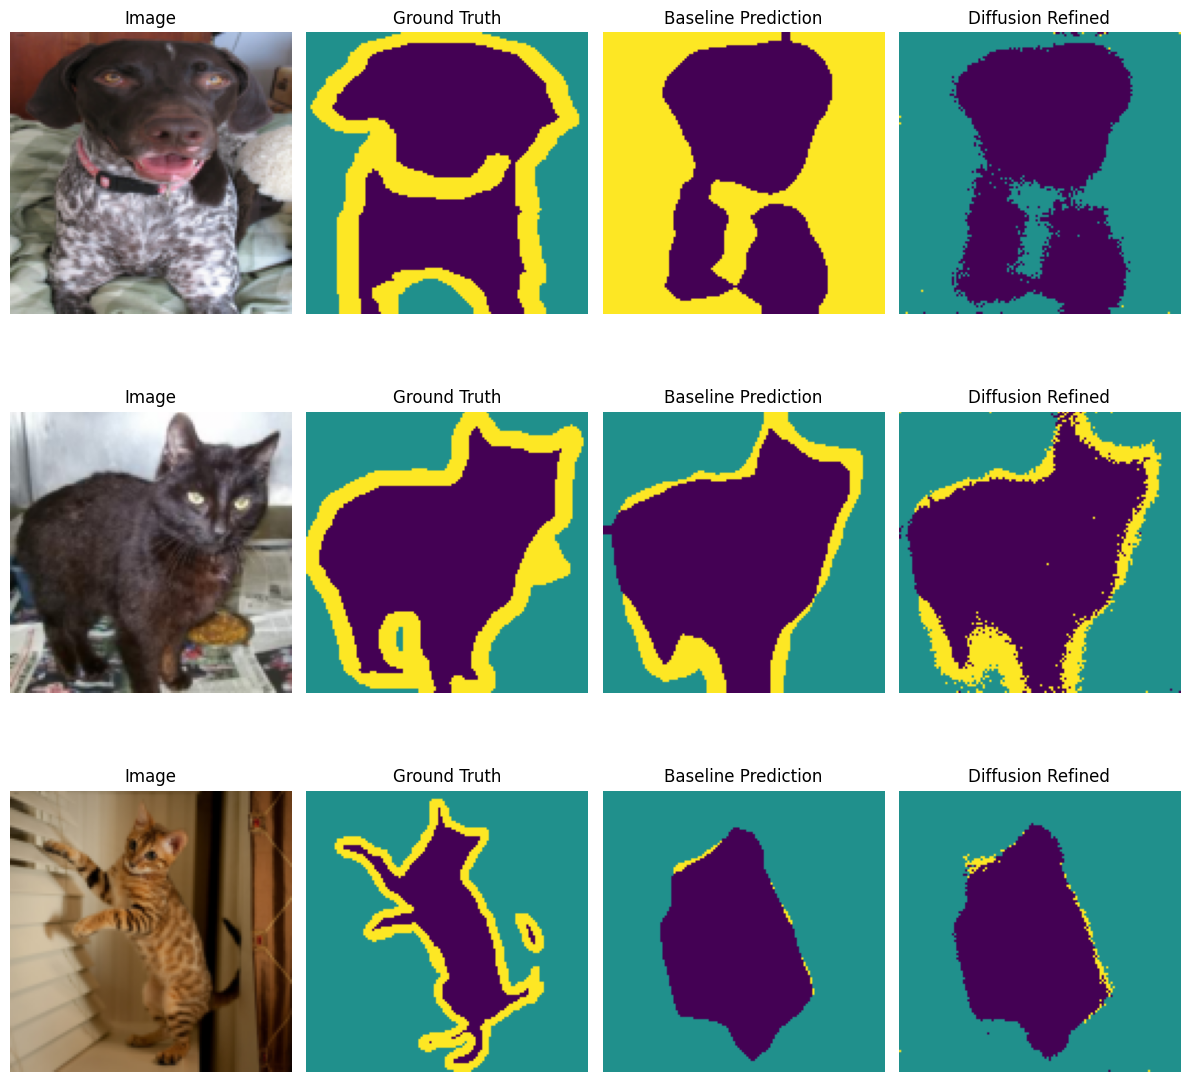

In [161]:
# Visualization
n_vis = 3
images, masks = next(iter(test_loader))
images, masks = images[:n_vis].to(device), masks[:n_vis].to(device)

plt.figure(figsize=(12, n_vis * 4))

# Initialize IoU metric on the same device
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(device)

with torch.no_grad():
    # Baseline predictions
    if BASELINE_MODEL.lower() == "unet":
        logits = baseline_model(images)
    else:
        logits = baseline_model(images)["out"]

    baseline_probs = F.softmax(logits, dim=1)
    preds_baseline = torch.argmax(baseline_probs, dim=1)

    # Compute IoU for baseline
    iou_baseline = iou_metric(preds_baseline, masks.long()).item()

    # Diffusion refinement
    refined_batch = []
    for i in range(n_vis):
        refined = refine_with_diffusion(
            images[i],
            baseline_model,
            diffusion_model,
            ddpm_scheduler,
            num_steps=10
        )
        refined_batch.append(refined.to(device))

    refined_batch = torch.stack(refined_batch)
    preds_refined = torch.argmax(refined_batch, dim=1)

    # Compute IoU for refined predictions
    iou_refined = iou_metric(preds_refined, masks.long()).item()

# Print IoUs
print(f"\nBaseline IoU (visual samples): {iou_baseline:.4f}")
print(f"Refined IoU (visual samples):  {iou_refined:.4f}\n")

# --- Plot results ---
for i in range(n_vis):
    img = images[i].cpu()
    if BASELINE_MODEL.lower() == "deeplabv3":
        img = denormalize(img, mean, std)
    img = img.permute(1, 2, 0).numpy().clip(0, 1)

    gt = masks[i].cpu().numpy()
    pr_b = preds_baseline[i].cpu().numpy()
    pr_r = preds_refined[i].cpu().numpy()

    plt.subplot(n_vis, 4, i * 4 + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(n_vis, 4, i * 4 + 2)
    plt.imshow(gt)
    plt.axis("off")
    plt.title("Ground Truth")

    plt.subplot(n_vis, 4, i * 4 + 3)
    plt.imshow(pr_b)
    plt.axis("off")
    plt.title("Baseline Prediction")

    plt.subplot(n_vis, 4, i * 4 + 4)
    plt.imshow(pr_r)
    plt.axis("off")
    plt.title("Diffusion Refined")

plt.tight_layout()
plt.show()
